# Clustering Antarctic Penguin Species

In this project, I perform a cluster analysis of penguins in Antarctic to identify groups in the data. 

**The dataset consists of 5 columns.**

Column | Description
:--- | :---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

While the penguin species are not recorded, it is known that there are **at least three** species native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.

The idea and dataset for this project are from [this DataCamp project](https://app.datacamp.com/learn/projects/1809).

## Load and inspect data

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

In [3]:
# Load and inspect dataset
penguins_df = pd.read_csv("penguins.csv")
print(penguins_df.info())
penguins_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
culmen_length_mm     332 non-null float64
culmen_depth_mm      332 non-null float64
flipper_length_mm    332 non-null float64
body_mass_g          332 non-null float64
sex                  332 non-null object
dtypes: float64(4), object(1)
memory usage: 13.0+ KB
None


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


## Prepare data for clustering

Let's transform the `sex` column into numerical data.

In [4]:
sex_dummies = pd.get_dummies(penguins_df["sex"])
penguins = pd.concat([penguins_df.select_dtypes("number"), sex_dummies], axis="columns")
penguins.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,FEMALE,MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
3,36.7,19.3,193.0,3450.0,1,0
4,39.3,20.6,190.0,3650.0,0,1


## Hyperparameter tuning: find the optimum number of clusters

To get the optimum number of clusters, we build some models using a range of `n_cluster` values for the `KMeans` object, each time getting the `inertia` and `silhouette_score`.

The value of the `n_cluster` at which the `inertia` does not change sharply (at which there is "a bend in the elbow") is the optimum number of clusters. If this is not clear enough, we can confirm it using the `silhouette_score` metric. Given a range of possible optimum `n_clusters`, the one at which the `silhouette_score` is maximum is the optimum number of clusters.

In [6]:
inertia_values = []
silhouette_scores = []
n_clusters = range(2, 13)

for i in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=i, random_state=42))
    model.fit(penguins)
    inertia_values.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(penguins, model.named_steps["kmeans"].labels_))

Let's visualize `inertia_values` versus `n_clusters`.

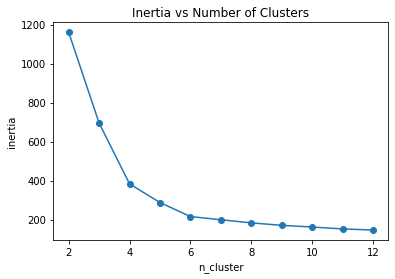

In [8]:
plt.plot(n_clusters, inertia_values, marker="o")
plt.xlabel("n_cluster")
plt.ylabel("inertia")
plt.title("Inertia vs Number of Clusters")
plt.show()

The optimum `n_cluster` seems to fall between 4 and 6. We can confirm this by visualizing `silhouette_scores` against `n_clusters`.

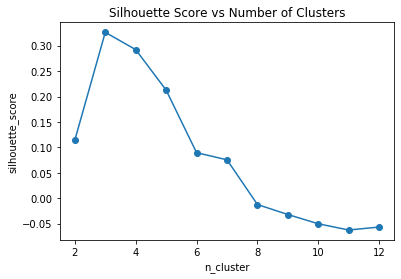

In [9]:
plt.plot(n_clusters, silhouette_scores, marker="o")
plt.xlabel("n_cluster")
plt.ylabel("silhouette_score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

Of the `n_cluster` values from 4 to 6, 4 has the highest `silhouette_score`. This implies that 4 is the optimum number of clusters.

Let's use this value to build a final model.

## Build model

In [11]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=42))
final_model.fit(penguins)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=4, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0))],
         verbose=False)

## Visualize clusters

Let's see how the data points are clustered by visualizing the relationships between different features.

In [13]:
# Get cluster labels for each data record
labels = final_model.named_steps["kmeans"].labels_

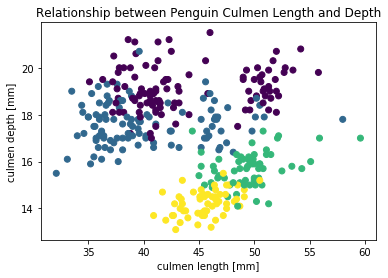

In [14]:
plt.scatter(penguins["culmen_length_mm"], penguins["culmen_depth_mm"], c=labels)
plt.title("Relationship between Penguin Culmen Length and Depth")
plt.xlabel("culmen length [mm]")
plt.ylabel("culmen depth [mm]")
plt.show()

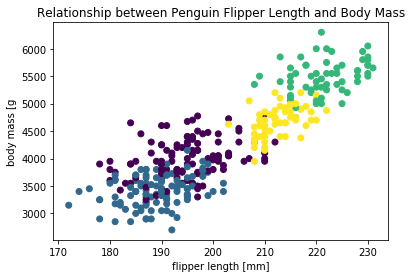

In [16]:
plt.scatter(penguins["flipper_length_mm"], penguins["body_mass_g"], c=labels)
plt.title("Relationship between Penguin Flipper Length and Body Mass")
plt.xlabel("flipper length [mm]")
plt.ylabel("body mass [g")
plt.show()

The four clusters are pretty well distinguished in the above visualizations.

## Find feature means for each cluster

In [29]:
# Create `cluster` column
penguins_num = penguins_df.select_dtypes("number")
penguins_num["cluster"] = labels

# Group by `label` and evaluate means
penguins_gb = penguins_num.groupby("cluster").mean()
penguins_gb

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
cluster,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,40.217757,17.611215,189.046729,3419.158879
2,49.473770,15.718033,221.540984,5484.836066
3,45.563793,14.237931,212.706897,4679.741379


## Visualize relationships between clusters

We'll visualize `culmen_length` and `culmen_depth` in one plot, `flipper_length` in another, and `body_mass` in the last. I've decided not to use the same plot for all the features because of the wide difference between the range of values across the features.

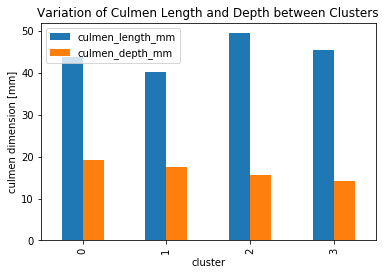

In [34]:
penguins_gb[["culmen_length_mm", "culmen_depth_mm"]].plot(kind="bar")
plt.title("Variation of Culmen Length and Depth between Clusters")
plt.ylabel("culmen dimension [mm]")
plt.show()

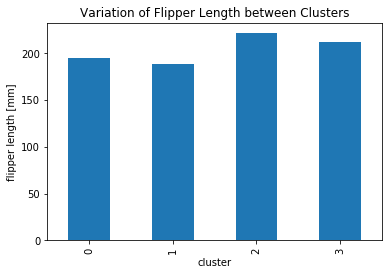

In [35]:
penguins_gb["flipper_length_mm"].plot(kind="bar")
plt.title("Variation of Flipper Length between Clusters")
plt.ylabel("flipper length [mm]")
plt.show()

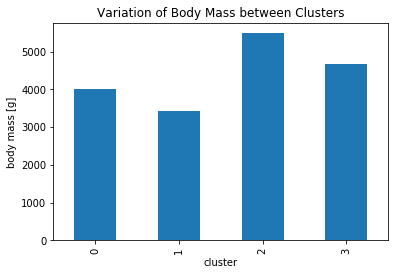

In [36]:
penguins_gb["body_mass_g"].plot(kind="bar")
plt.title("Variation of Body Mass between Clusters")
plt.ylabel("body mass [g]")
plt.show()

Cluster 2 penguins seem to be the heaviest and have the longest culmens and flippers.